In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import tensorflow as tf

In [11]:
BASE_URL = "https://www.datos.gov.co/resource/g48d-yu62.json"

def fetch_data(limit=50000):
    all_data, offset = [], 0
    while True:
        url = f"{BASE_URL}?$limit={limit}&$offset={offset}"
        resp = requests.get(url)
        resp.raise_for_status()
        batch = resp.json()
        if not batch:
            break
        all_data.extend(batch)
        offset += limit
    return pd.DataFrame(all_data)

df = fetch_data()
print("Shape final:", df.shape)
df.head()


Shape final: (298, 9)


,a_o,codigo_departamento,departamento,codigo_municipio,municipio,hectareas_con_permisos,hectareas_en_transito_a,hectareas_explotacion_ilicita,total_evidencia_explotacion
0,2018,5,ANTIOQUIA,5031,AMALFI,268.715581,55.921508,959.929273,1284.566362
1,2018,5,ANTIOQUIA,5040,ANORÍ,397.950798,52.438321,1237.886069,1688.275188
2,2018,5,ANTIOQUIA,5120,CÁCERES,1809.804942,379.56547,3050.15314,5239.523552
3,2018,5,ANTIOQUIA,5134,CAMPAMENTO,0,0,1.639286,1.639286
4,2018,5,ANTIOQUIA,5154,CAUCASIA,1034.647431,60.678633,369.128129,1464.454193


In [12]:
numeric_cols = [
    "a_o",
    "hectareas_con_permisos",
    "hectareas_en_transito_a",
    "hectareas_explotacion_ilicita",
    "total_evidencia_explotacion"
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["a_o","departamento","municipio"])
print("Datos limpios:", df.shape)
df.describe()


Datos limpios: (298, 9)


,a_o,hectareas_con_permisos,hectareas_en_transito_a,hectareas_explotacion_ilicita,total_evidencia_explotacion
count,298.000000,298.000000,298.000000,298.000000,298.000000
mean,2019.003356,258.705013,68.963285,648.255308,975.923606
std,0.822652,801.193666,177.198094,1027.599695,1658.315198
min,2018.000000,0.000000,0.000000,0.000000,0.135000
25%,2018.000000,0.000000,0.000000,29.037118,39.017314
50%,2019.000000,0.000000,0.000000,118.411792,149.700568
75%,2020.000000,87.950206,48.803342,949.978029,1350.620114
max,2020.000000,6633.406001,1249.061011,5203.474824,8841.932834


departamento
CHOCÓ              83603.967720
ANTIOQUIA          59213.798430
BOYACA             18671.981255
CORDOBA            13086.502303
NARIÑO              8019.650541
CAUCA               6427.094464
VALLE DEL CAUCA     2261.790003
PUTUMAYO            1013.351713
GUAINÍA              458.437493
CALDAS               237.253309
Name: hectareas_explotacion_ilicita, dtype: float64


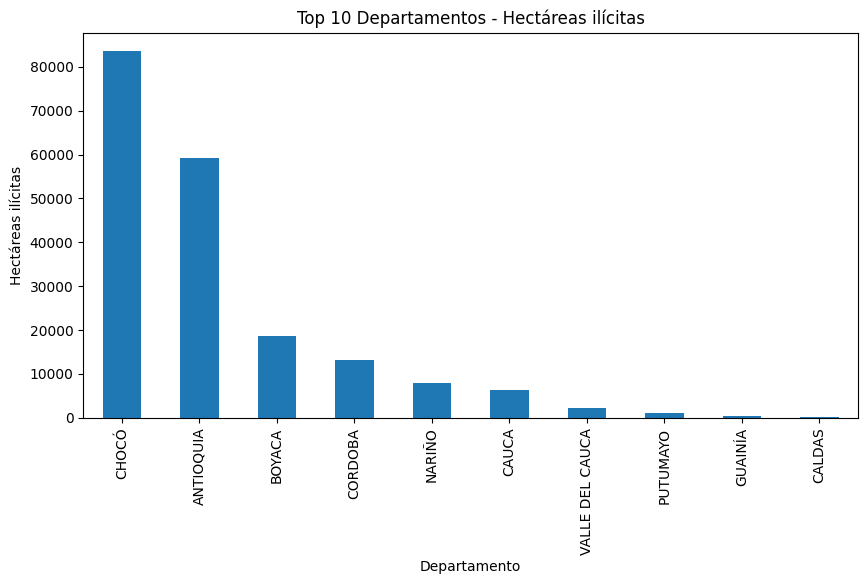

In [13]:
ranking = (
    df.groupby("departamento")["hectareas_explotacion_ilicita"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

print(ranking)

ranking.plot(kind="bar", figsize=(10,5), title="Top 10 Departamentos - Hectáreas ilícitas")
plt.ylabel("Hectáreas ilícitas")
plt.xlabel("Departamento")
plt.show()

In [14]:
features = [
    "hectareas_con_permisos",
    "hectareas_en_transito_a",
    "total_evidencia_explotacion"
]
target = "hectareas_explotacion_ilicita"

df_ml = df.dropna(subset=features + [target])

X = df_ml[features].values.astype(np.float32)
y = df_ml[target].values.astype(np.float32)

# Split 80/20 manual
n = len(X)
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

train_size = int(n * 0.8)
train_idx, test_idx = idx[:train_size], idx[train_size:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Normalización
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [15]:
def train_with_tf(X_train, y_train, epochs=1000, lr=0.0001):
    X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_train = tf.reshape(tf.convert_to_tensor(y_train, dtype=tf.float32), (-1, 1))

    W = tf.Variable(tf.random.normal([X_train.shape[1], 1]))
    b = tf.Variable(tf.zeros([1]))

    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            y_pred = tf.matmul(X_train, W) + b
            loss = tf.reduce_mean(tf.square(y_pred - y_train))

        grads = tape.gradient(loss, [W, b])
        optimizer.apply_gradients(zip(grads, [W, b]))

        if epoch % 200 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy():.4f}")

    return W, b

W, b = train_with_tf(X_train, y_train)


Epoch 0, Loss: 1589730.0000
Epoch 200, Loss: 1444984.8750
Epoch 400, Loss: 1318474.1250
Epoch 600, Loss: 1207703.7500
Epoch 800, Loss: 1110534.0000


In [16]:
# Predicciones
y_pred = tf.matmul(tf.convert_to_tensor(X_test, dtype=tf.float32), W) + b
y_pred = y_pred.numpy().flatten()

# MSE y R² con NumPy
mse = np.mean((y_test - y_pred) ** 2)
ss_res = np.sum((y_test - y_pred) ** 2)
ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f"[INFO] Evaluación en test MSE = {mse:.2f}")
print(f"R² en test = {r2:.3f}")


[INFO] Evaluación en test MSE = 665699.06
R² en test = 0.121


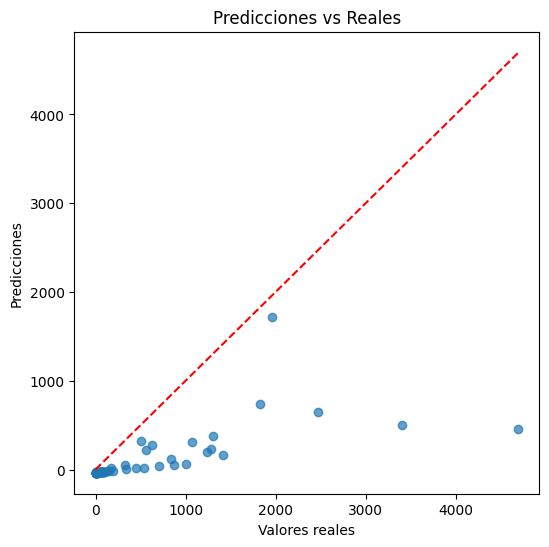

In [17]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Reales")
plt.show()
